<a href="https://colab.research.google.com/github/anelglvz/Working-Analyst/blob/main/ML-AI-for-the-Working-Analyst/Semana11/Semana11_Resumen_de__textos_seq2seq_LSTM_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Antes de iniciar cambiar entorno de ejecución a GPU

# Cargar bibliotecas y Embeddings preentrenados

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 34.2 MB/s 
     |████████████████████████████████| 110 kB 61.2 MB/s 


<h3>Bibliotecas<h3>

In [ ]:
import pandas as pd
import numpy as np
import gensim
import contractions
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.data import Dataset  # Convierte conjuntos de datos de Python a tensores
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  # Crear diccionario para convertir palabras a indices y vs.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Rellenar con cero los vectores de las secuencias hasta la longitud máxima
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate #, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h3>Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés. 
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [ ]:
# asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
file =  '/content/drive/MyDrive/Curso-WorkingAnalyst/semana11/GoogleNews-vectors-negative300.bin.gz'  
w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

In [ ]:
print('Palabras en el modelo w2v: {:,} '.format(len(w2v.vocab)))
print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


In [ ]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 5.02 s, sys: 237 ms, total: 5.26 s
Wall time: 5.26 s


In [ ]:
dic_embeddings_word2vec['view'].shape

(300,)

# Funciones

In [ ]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [ ]:
def Vectorizer(serie_pd, max_tokens= 20000):
    '''Crear diccionario para convertir palabras en índices
     '''
    text_ds = Dataset.from_tensor_slices(serie_pd).batch(128)  # transforma la serie a tensores
    vectorizer = TextVectorization(max_tokens = max_tokens  )  
    vectorizer.adapt(text_ds)   #Computes a vocabulary of string terms from tokens in a dataset. 
    return  vectorizer

In [ ]:
def vectores_palabras(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    '''Obtiene una matriz donde cada renglón es el 'embedding vector' de una 
    palabra del vocabulario '''
    num_tokens = len(dic_vocabulario.keys()) 
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # los vectores no encontrados en el embeding se quedan en cero
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [ ]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  palabras_indices_resumen['tokenstart']
    stop_condition = False
    decoded_sentence = ''
    t=0
    sampled_token = ''
    while stop_condition == False:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Escoje la próxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = indices_palabras_resumen[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+ sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or t >= (longitud_max_resumen-1)):
            stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c
        t+=1

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    '''obtiene el resumen, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if((i != 0 and i != palabras_indices_resumen['tokenstart']) and i != palabras_indices_resumen['tokenend']):
        newString = newString + indices_palabras_resumen[i]+' '
    return newString

def seq2text(input_seq):
    '''obtiene la reseña, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + indices_palabras_reseña[i]+' '
    return newString

# Lectura de Datos y preparación de secuencias

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana11/Reviews.csv',
                 nrows=500000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(353877, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 244521
Great snack at a steep price
As I become more health conscious, I continually look for snacks to satisfy my sweet and crunchy cravings. While on vacation in the US I found this in a store for much less than they are offering here, but if I want this I will have to pay the price. They taste great, not too sweet and the nuts are crunchy enough to satisfy me. 5 pieces are supposed to be about 170 calories, so I don't feel too guilty enjoying this.

Review # 324431
My moment of Zen
I have always loved the flavor of peaches.  Maybe it's because there was a peach tree in my grandmother's back yard and the taste of peaches takes me back to the warm and cozy feelings of childhood memories.  Sipping this wonderfully peachy tea makes me think of simpler, less complicated times and let's me know that, at least for the moment, all is well.  The peach flavor is natural and true and the zing that's added by the hint of ginger compliments the peach flavor perfectly.  And it's calorie

## Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [ ]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)


CPU times: user 24.9 s, sys: 134 ms, total: 25.1 s
Wall time: 27.8 s


In [ ]:
df

,Summary,Text
0,good quality dog food,i have bought several of the vitality canned d...
1,not as advertised,product arrived labeled as jumbo salted peanut...
2,delight says it all,this is a confection that has been around a fe...
3,cough medicine,if you are looking for the secret ingredient i...
4,great taffy,great taffy at a great price there was a wide ...
...,...,...
353875,best tasting of any peanutbutter,we have used smucker s natural sometimes organ...
353876,though i eat the unsalted variety 120 mg of sa...,contents peanuts 120 mg salt still 100 natural...
353877,lower the price,i can only eat sugar free pb and if amazon low...
353878,smuckers natural peanut butter,beware this is a 16oz jar not 26 oz jar a jar ...


## Agregar token que identifique el inicio y el final de la secuencia objetivo (resúmenes).

In [ ]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 268242
tokenstart great taste  tokenend
great strong tasting gum but does not last long but is still worth it especially if your not allowed to have regular sf gum the cinnamon taste is very great 

Review # 223799
tokenstart freshness of gg bran crispbread tokenend
i thought these packages of gg bran crispbread were not as fresh as i have had in the past i ordered out of toronto the last couple of times but wanted to order from within the usa and did so this time but feel a little disappointed i am eating them but find i need to let the topping soak into them to soften them a little more but they are still tasty do not think i feel they are not eatable because they are they just seem to be a little hard 

Review # 147934
tokenstart chocolatey fudgy chewy goodness tokenend
these cookies were a huge hit in our house i normally avoid fudge filled or coated cookies because i find them too sweet these new chips ahoy gooey megafudge cookies are so good i could not resist they are 

## Fijar longitud máxima de palabras en textos y resumenes

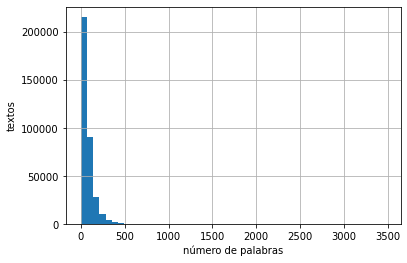


El 90% de los textos tiene 164 palabras


In [ ]:
# ¿Cuantas palabras tienen cada texto?
palabras_reseña = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_reseña.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_reseña.quantile(0.90)))

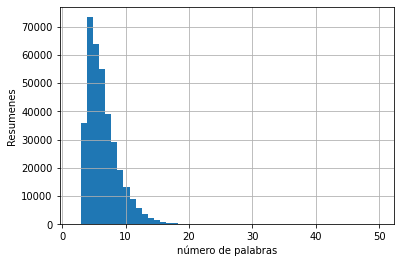


El 97.5% de los resumenes tiene 13 palabras


In [ ]:
# ¿Cuantas palabras tienen cada titulo?
palabras_resumen = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_resumen.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("Resumenes")
plt.show()

print('\nEl 97.5% de los resumenes tiene {:,.0f} palabras'.format(palabras_resumen.quantile(0.975)))

In [ ]:
longitud_max_reseña = palabras_reseña.quantile(0.90)     #164 palabras    168
longitud_max_resumen = palabras_resumen.quantile(0.975)  # 13 palabras

In [ ]:
longitud_max_reseña, longitud_max_resumen

(164.0, 13.0)

In [ ]:
datos =  df[(palabras_reseña <= longitud_max_reseña ) & (palabras_resumen <= longitud_max_resumen)]
datos.shape   

(314849, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)
print('{} reseñas en el conjunto de entrenamiento\n{} reseñas en el conjunto de prueba'.format(len(x_train), len(x_test)))

283364 reseñas en el conjunto de entrenamiento
31485 reseñas en el conjunto de prueba


# Preparar las secuencias para ingresar al modelo

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


### 1)  Identificar cada palabra con un valor numérico

In [ ]:
%%time
vectorizer_reseña = Vectorizer(x_train)

# Diccionarios de la secuencia de entrada
voc_reseña = vectorizer_reseña.get_vocabulary()  # lista con el vocabulario
palabras_indices_reseña = dict(zip(voc_reseña, range(len(voc_reseña))))
indices_palabras_reseña = dict(map(reversed, palabras_indices_reseña.items()))

CPU times: user 8.35 s, sys: 1.41 s, total: 9.76 s
Wall time: 10.5 s


In [ ]:
palabras_indices_reseña.keys()

[UNK] es un token especial que se usara cuando se encuentren palabras que no están en el vocabulario.

In [ ]:
vectorizer_resumen = Vectorizer(y_train)
# Diccionarios de la secuencia de entrada
voc_resumen = vectorizer_resumen.get_vocabulary()  # lista con el vocabulario
palabras_indices_resumen = dict(zip(voc_resumen, range(len(voc_resumen))))
indices_palabras_resumen = dict(map(reversed, palabras_indices_resumen.items()))


In [ ]:
ejemplos = x_train.iloc[:2]
for ej in ejemplos:
  print(len(ej.split()))
  print(ej)

16
my husband s favorite biscuit cookie with tea plain but tasty hard to find in america 
44
i received this coffee as a bunco prize i love coffee but tend to dislike flavored coffee due to the strange aftertaste so many leave behind this coffee had great flavor and no aftertaste i definitely recommend it i am searching for more now 


In [ ]:
ejemplos_vec = ejemplos.apply(vectorizer_reseña)
for ej in ejemplos_vec:
  print(len(ej))
  print(ej)

16
tf.Tensor(
[  14  312   61  135 2479  485   20   50  526   17  199  185    7   79
   13 2340], shape=(16,), dtype=int64)
44
tf.Tensor(
[   3  280    9   42   23    5    1 6590    3   48   42   17 1194    7
 2787  341   42  710    7    2 1365  572   26  146  716 2269    9   42
   54   30   41    4   62  572    3  205  129    6    3   46 1351   12
   55   97], shape=(44,), dtype=int64)


In [ ]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_resumen)
y_test_vec = y_test.apply(vectorizer_resumen)

CPU times: user 1h 2min 34s, sys: 5min 11s, total: 1h 7min 46s
Wall time: 1h 3s


## 2) Rellenar cada secuencia hasta alcanzar la longitud máxima

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

ejemplos_seq =  pad_sequences(ejemplos_vec, maxlen = int(longitud_max_reseña), padding='post')
for ej in ejemplos_seq:
  print(len(ej))
  print(ej)

164
[  14  312   61  135 2479  485   20   50  526   17  199  185    7   79
   13 2340    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
164
[   3  280    9   42   23    5    1 6590    3   48   42   17 1194    7
 2787  341   42  710    7    2 1365  572   26  146  716 2269    9   42
   54   30   41  

In [ ]:
%%time

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_reseña), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_reseña), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_resumen) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_resumen) , padding='post') 

CPU times: user 3min 54s, sys: 13.4 s, total: 4min 7s
Wall time: 3min 43s


## 3) Obtener la matriz de vectores para todas las palabras del vocabulario 

In [ ]:
embedding_matrix_reseña = vectores_palabras(palabras_indices_reseña, dic_embeddings_word2vec , 300)
embedding_matrix_reseña.shape

17825 palabras vectorizadas, que representan 89.1% de todas las palabras en el corpus


(20000, 300)

In [ ]:
embedding_matrix_reseña

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       ...,
       [ 0.18359375,  0.33203125,  0.00485229, ..., -0.44140625,
         0.12011719, -0.04492188],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08447266,  0.06494141, -0.23144531, ..., -0.04077148,
        -0.11181641, -0.06542969]])

In [ ]:
embedding_matrix_resumen = vectores_palabras(palabras_indices_resumen, dic_embeddings_word2vec , 300)
embedding_matrix_resumen.shape

14580 palabras vectorizadas, que representan 72.9% de todas las palabras en el corpus


(20000, 300)

## Guardamos en pickle los avances

In [ ]:
import pickle
path = '/content/drive/MyDrive/Colab Notebooks/Working Analyst/ML_AI_for_the_Working_Analyst/Semana11/'
tuple_inputs = ((embedding_matrix_resumen, embedding_matrix_reseña),
                (x_train_seq, x_test_seq,  y_train_seq, y_test_seq),
                (palabras_indices_resumen, palabras_indices_reseña),
                (indices_palabras_resumen, indices_palabras_reseña),
                (longitud_max_resumen, longitud_max_reseña)
                )
pickle.dump(tuple_inputs, open (path + "tuple_inputs_RNN_v2207_.pkl", 'wb'))

# Leemos los datos guardados

In [ ]:
import pickle
path = '/content/drive/MyDrive/Colab Notebooks/Working Analyst/ML_AI_for_the_Working_Analyst/Semana11/'
tuple_inputs = pickle.load(open(path + "tuple_inputs_RNN_v2207_.pkl", 'rb'))

embedding_matrix_resumen, embedding_matrix_reseña = tuple_inputs[0]
x_train_seq, x_test_seq,  y_train_seq, y_test_seq = tuple_inputs[1]
palabras_indices_resumen, palabras_indices_reseña = tuple_inputs[2]
indices_palabras_resumen, indices_palabras_reseña = tuple_inputs[3]
longitud_max_resumen,     longitud_max_reseña     = tuple_inputs[4]


# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## ENCODER  y DECODER


In [ ]:
num_tokens_reseña = len(palabras_indices_reseña) 
num_tokens_resumen = len(palabras_indices_resumen)
embedding_dim = 300

In [ ]:
K.clear_session() 
latent_dim = 320  # neuronas ocultas en cada LSTM en cada tiempo t.

# ENCODER   ================================================================

## EMBEDDING
#recibe los indices que corresponden a las palabras de las reseñas y las 
#regresa con el vector correpondiente del embedding

encoder_inputs = Input(shape = (int(longitud_max_reseña),))

enc_emb_lay = Embedding(num_tokens_reseña, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_reseña),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)     

#LSTM 1
# procesa la secuencia de entrada y regresa otra secuencia que pasara a la
# capa LSTM 2 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara a la capa LSTM 3
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara al mecanismo de atención y los estados h y c inicializarán
# el decodificador.

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_resumen, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_resumen),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_state_h, decoder_state_c = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




## Mecanismo de atención

 [Fuente ](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.Attention()

  def call(self, query, value,
          #  mask
           ):
    # shape_checker = ShapeChecker()
    # shape_checker(query, ('batch', 't', 'query_units'))
    # shape_checker(value, ('batch', 's', 'value_units'))
    # shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    # shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    # value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        # mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    # shape_checker(context_vector, ('batch', 't', 'value_units'))
    # shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
attention = BahdanauAttention(latent_dim)

In [ ]:
context_vector, attention_weights = attention(decoder_outputs, encoder_outputs) # (query, value)

In [ ]:
# Unión del decoder con la capa de atención

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, context_vector])

# El Decoder calcula su salida mediante Softmax, que crea el vector de probabilidad 
# para determinar la secuencia final.

decoder_dense = TimeDistributed(Dense(embedding_matrix_resumen.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo de entrenamiento

In [ ]:
# Modelo definitivo

# Tupla con las entradas y las salidas
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



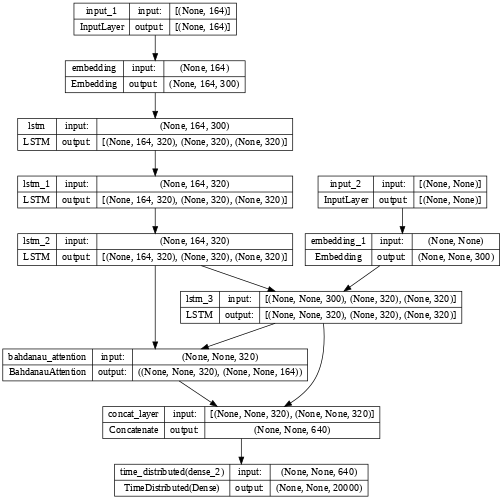

In [ ]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 164)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 164, 300)     6000000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 164, 320),   794880      ['embedding[0][0]']              
                                 (None, 320),                                                     
                                 (None, 320)]                                                     
                                                                                              

## Compilación  del Modelo

Es el paso final en la creación del modelo antes del entrenamiento.

Requiere elegir una [**función de pérdida**](https://keras.io/api/losses/), que se usa para calcular el error en el proceso de aprendizaje, un algoritmo para [**optimizar**](https://keras.io/api/optimizers/) los pesos mediante la comparación de las predicciones y la función de pérdida elegida ([¿cómo escoger el optimizador?](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)).



In [ ]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

### Entrenamiento

In [ ]:
#%%time

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 12,
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/12
554/554 [==============================] - 432s 760ms/step - loss: 2.2138 - val_loss: 1.9475
Epoch 2/12
554/554 [==============================] - 427s 771ms/step - loss: 1.9041 - val_loss: 1.8229
Epoch 3/12
554/554 [==============================] - 433s 782ms/step - loss: 1.7789 - val_loss: 1.7140
Epoch 4/12
125/554 [=====>........................] - ETA: 5:24 - loss: 1.6937

KeyboardInterrupt: ignored

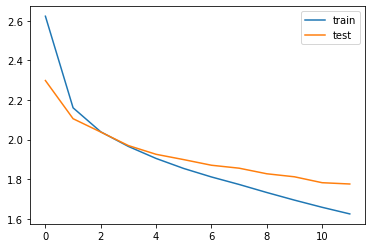

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Working Analyst/ML_AI_for_the_Working_Analyst/Semana11/WeightsM_rev-220727')

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Working Analyst/ML_AI_for_the_Working_Analyst/Semana11/WeightsM_rev-220727')

#Modelo de Inferencia

In [ ]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

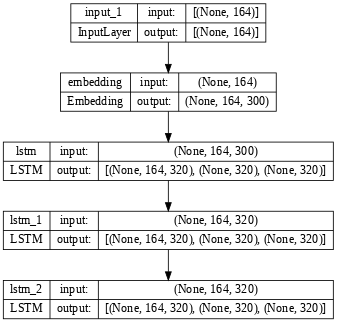

In [ ]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

In [ ]:
# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_reseña), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attention = BahdanauAttention(latent_dim)
context_vector, _ = attention( decoder_outputs2, decoder_hidden_state_input,)
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, context_vector])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

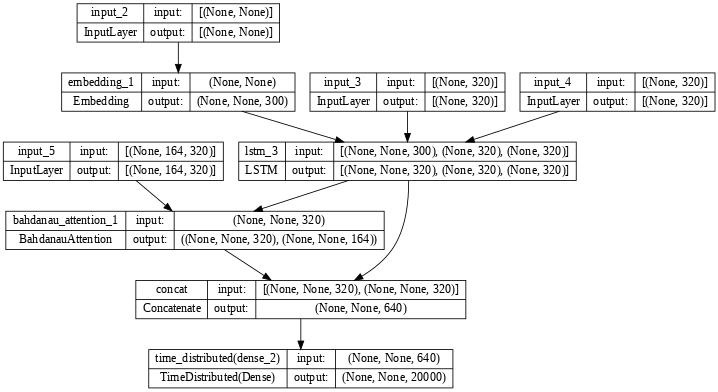

In [ ]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

## Predicciones


**Implementación del modelo de inferencia **
[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

<h3> Comparación del resumen generado por la rnn con el resumen original

In [ ]:
for i in range(105,120):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

105
Reseña: thin runny and the fake milk powder used to add creaminess has an off flavor better off eating your ceramic mug 
Resumen original: not good 
1/1 [==============================] - 0s 17ms/step
Resumen generado:  great product


106
Reseña: this is a really strong wonderful coffee not bitter in any way it is the only one we drink now great product 
Resumen original: great coffee 
1/1 [==============================] - 0s 16ms/step
Resumen generado:  great


107
Reseña: i love this stuff and it is hard to find sugar free makes it good for me i recommend it highly even my husband likes it and plans to have me send him off to the [UNK] golf course with a thermos full of this along with a flash of tequila or brandy lol 
Resumen original: perfect for the cold weather 
1/1 [==============================] - 0s 19ms/step
Resumen generado:  great product


108
Reseña: a neighbor gave me 2 cans and my cat loved it ate it a few times but then only drank the broth donated the remaining